# Домашнее задание №1

Для работы используется датасет Diabetes Prediction ([Kaggle](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data)).

## Import

In [1]:
import pandas as pd  # Библиотека Pandas для работы с табличными данными
import numpy as np  # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt  # библиотека Matplotlib для визуализации
import seaborn as sns  # библиотека seaborn для визуализации
import plotly.graph_objects as go  # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px  # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import (
    MinMaxScaler,
)  # Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import (
    StandardScaler,
)  # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import (
    PowerTransformer,
)  # Степенное преобразование от scikit-learn

# предварительная обработка категориальных признаков
from sklearn.preprocessing import (
    OneHotEncoder,
)  # Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import (
    OrdinalEncoder,
)  # Импортируем Порядковое кодирование от scikit-learn

from sklearn.pipeline import Pipeline  # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer  # т.н. преобразователь колонок

from sklearn.base import (
    BaseEstimator,
    TransformerMixin,
)  # для создания собственных преобразователей / трансформеров данных

from sklearn.neighbors import (
    KNeighborsRegressor,
)  # Регрессия К-Ближайших соседей от scikit-learn

from sklearn.model_selection import (
    train_test_split,
)  #  функция разбиения на тренировочную и тестовую выборку

# в исполнении scikit-learn
from sklearn.model_selection import (
    ShuffleSplit,
)  # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import (
    cross_validate,
)  # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse  # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score  # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay  # Класс визуализации ошибок модели

from sklearn.model_selection import (
    RandomizedSearchCV,
)  # для поиска при случайном сэмплировании гиперпараметров
import scipy.stats as stats  # статистические функции библиотеки scipy

from sklearn.compose import TransformedTargetRegressor

from sklearn.model_selection import GridSearchCV  # для поиска по сетке гиперпараметров

from sklearn.metrics import (
    make_scorer,
)  # функция для создания объекта из метрики для использования в кросс-валидации

## Работа с данными

Ранее предварительная обработка была выполнена в рамках [этой](https://github.com/synrocka/Diabetes-Prediction/blob/main/EDA.ipynb) работы, поэтому просто скопируем из неё нужные функции.  
Из обработки исключена колонка "bmi", поскольку она является целевой и будет обработана отдельно.

In [2]:
DF = pd.read_csv(
    "https://raw.githubusercontent.com/synrocka/Diabetes-Prediction/main/data/clean_diabetes_prediction_db.csv",
    delimiter=",",
)
DF

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,False,True,non-smoker,25.19,6.6,140,False
1,Female,54.0,False,False,non-smoker,27.32,6.6,80,False
2,Male,28.0,False,False,non-smoker,27.32,5.7,158,False
3,Female,36.0,False,False,current,23.45,5.0,155,False
4,Male,76.0,True,True,current,20.14,4.8,155,False
...,...,...,...,...,...,...,...,...,...
96123,Female,36.0,False,False,non-smoker,24.60,4.8,145,False
96124,Female,2.0,False,False,non-smoker,17.37,6.5,100,False
96125,Male,66.0,False,False,past_smoker,27.83,5.7,155,False
96126,Female,24.0,False,False,non-smoker,35.42,4.0,100,False


In [3]:
cat_columns = ["gender", "hypertension", "heart_disease", "smoking_history", "diabetes"]
num_columns = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

In [4]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include="number"):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include="number"):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = (X[col] < low_quantile) | (X[col] > high_quantile)
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [5]:
num_pipe_age_HbA1c_glucose = Pipeline(
    [
        (
            "QuantReplace",
            QuantileReplacer(
                threshold=0.01,
            ),
        ),
        ("power", PowerTransformer()),
    ]
)
num_age_HbA1c_glucose = ["age", "HbA1c_level", "blood_glucose_level"]

cat_pipe_gender_hypertension_heart_diabetes = Pipeline([("encoder", OrdinalEncoder())])
cat_gender_hypertension_heart_diabetes = [
    "gender",
    "hypertension",
    "heart_disease",
    "diabetes",
]

cat_pipe_smoking = Pipeline(
    [
        (
            "encoder",
            OneHotEncoder(
                drop="if_binary", handle_unknown="ignore", sparse_output=False
            ),
        )
    ]
)
cat_smoking = ["smoking_history"]

# Сделаем отдельный Pipeline для числовых признаков:
preprocessors_num = ColumnTransformer(
    transformers=[
        ("num_age_HbA1c_glucose", num_pipe_age_HbA1c_glucose, num_age_HbA1c_glucose)
    ]
)

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(
    transformers=[
        ("num_age_bmi_HbA1c", num_pipe_age_HbA1c_glucose, num_age_HbA1c_glucose),
        (
            "cat_gender_hypertension_heart_diabetes",
            cat_pipe_gender_hypertension_heart_diabetes,
            cat_gender_hypertension_heart_diabetes,
        ),
        ("cat_smoking", cat_pipe_smoking, cat_smoking),
    ]
)

In [6]:
# Объединим названия колонок в один список
columns_num = np.hstack([num_age_HbA1c_glucose])

## Регрессия методом kNN

In [7]:
X, y = DF.drop(columns=["bmi"]), DF["bmi"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

### Оценим модель с использованием только числовых данных

In [8]:
X_train_prep = preprocessors_num.fit_transform(X_train)
X_val_prep = preprocessors_num.transform(X_val)

In [9]:
model = KNeighborsRegressor(n_neighbors=3, weights="distance")
model.fit(X_train_prep, y_train)

KNeighborsRegressor(n_neighbors=3, weights='distance')

### Оценка метрик

In [10]:
def calculate_metric(model_pipe, X, y, metric=r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [11]:
print(
    f"r2 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}"
)
print(f"r2 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

print(
    f"mse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse):.4f}"
)
print(
    f"mse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse):.4f}"
)

r2 на тренировочной выборке: 0.3273
r2 на валидационной выборке: -0.0495
mse на тренировочной выборке: 30.9069
mse на валидационной выборке: 47.7234


### Кросс-валидация

In [12]:
def cross_validation(X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv_rule)
    print("Ошибка на кросс-валидации")
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print("\n")
    print(DF_score.mean()[2:])

In [13]:
scoring_reg = {
    "R2": "r2",
    "-MSE": "neg_mean_squared_error",
    "-MAE": "neg_mean_absolute_error",
    "-Max": "max_error",
}

In [14]:
cross_validation(X_train_prep, y_train, model, scoring_reg, ShuffleSplit(n_splits=5))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.030281,0.021630,-0.055902,-48.576663,-5.089553,-70.25
1,0.027089,0.025733,-0.051083,-46.988475,-5.030899,-43.78
2,0.024627,0.022632,-0.040478,-45.670734,-4.982579,-47.19
3,0.026273,0.020493,-0.047777,-48.234503,-5.093065,-80.07
4,0.022527,0.023432,-0.058814,-47.287609,-4.993414,-80.07




test_R2      -0.050811
test_-MSE   -47.351597
test_-MAE    -5.037902
test_-Max   -64.272000
dtype: float64


### Визуализация ошибок

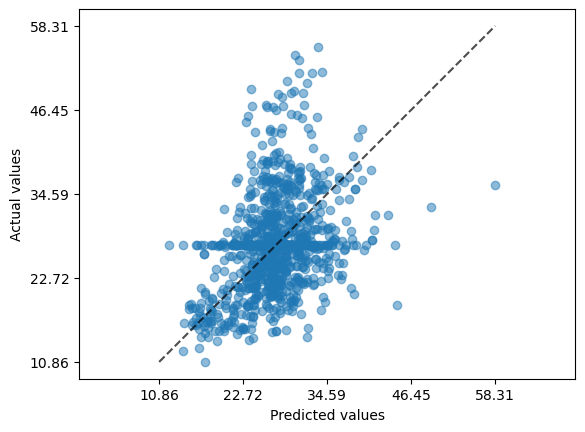

In [15]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)

### Поиск лучших гиперпараметров с помощью рандомизированного поиска

In [16]:
parameters = {"n_neighbors": stats.randint(1, 50), "weights": ["uniform", "distance"]}
n_iter_search = 20

kNN_search = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    verbose=3,
    param_distributions=parameters,
    cv=ShuffleSplit(n_splits=5),
    n_iter=n_iter_search,
)

In [17]:
kNN_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ..n_neighbors=46, weights=distance;, score=0.076 total time=   0.1s
[CV 2/5] END ..n_neighbors=46, weights=distance;, score=0.068 total time=   0.1s
[CV 3/5] END ..n_neighbors=46, weights=distance;, score=0.071 total time=   0.1s
[CV 4/5] END ..n_neighbors=46, weights=distance;, score=0.026 total time=   0.1s
[CV 5/5] END ..n_neighbors=46, weights=distance;, score=0.049 total time=   0.1s
[CV 1/5] END ..n_neighbors=30, weights=distance;, score=0.076 total time=   0.1s
[CV 2/5] END ..n_neighbors=30, weights=distance;, score=0.068 total time=   0.1s
[CV 3/5] END ..n_neighbors=30, weights=distance;, score=0.070 total time=   0.1s
[CV 4/5] END ..n_neighbors=30, weights=distance;, score=0.025 total time=   0.1s
[CV 5/5] END ..n_neighbors=30, weights=distance;, score=0.048 total time=   0.1s
[CV 1/5] END ..n_neighbors=33, weights=distance;, score=0.076 total time=   0.1s
[CV 2/5] END ..n_neighbors=33, weights=distance

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=None, train_size=None),
                   estimator=KNeighborsRegressor(), n_iter=20,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcf48fb3fe0>,
                                        'weights': ['uniform', 'distance']},
                   verbose=3)

In [18]:
kNN_search.best_estimator_

KNeighborsRegressor(n_neighbors=49)

In [19]:
kNNbest = kNN_search.best_estimator_
kNNbest.fit(X_train_prep, y_train)

KNeighborsRegressor(n_neighbors=49)

In [20]:
print(
    f"r2 на тренировочной выборке: {calculate_metric(kNNbest, X_train_prep, y_train):.4f}"
)
print(
    f"r2 на валидационной выборке: {calculate_metric(kNNbest, X_val_prep, y_val):.4f}"
)

print(
    f"mse на тренировочной выборке: {calculate_metric(kNNbest, X_train_prep, y_train, mse):.4f}"
)
print(
    f"mse на валидационной выборке: {calculate_metric(kNNbest, X_val_prep, y_val, mse):.4f}"
)

r2 на тренировочной выборке: 0.2699
r2 на валидационной выборке: 0.2341
mse на тренировочной выборке: 33.5451
mse на валидационной выборке: 34.8260


Рассмотрим результаты перебора

In [21]:
DF_reg = pd.DataFrame(kNN_search.cv_results_)
DF_results = DF_reg[
    [
        "param_n_neighbors",
        "param_weights",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF_results.sort_values(by="rank_test_score").style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
6,49,uniform,0.238659,0.010715,1
13,41,uniform,0.236475,0.011308,2
19,33,uniform,0.233371,0.010974,3
16,28,uniform,0.229095,0.011281,4
18,22,uniform,0.220704,0.013259,5
10,17,uniform,0.211134,0.014138,6
17,11,uniform,0.187493,0.014442,7
3,5,uniform,0.105347,0.014091,8
4,5,uniform,0.105347,0.014091,8
0,46,distance,0.057904,0.018642,10


### Выводы

- В сравнении с линейной регрессией в тех же условиях модель линейной регрессии справляется лучше (r2 `0.1279` против `0.2388`)
- Предпочтителен тип весов `'uniform'`
- Значительные ошибки появляются только с одним соседом

### Оценим влияние предварительной обработки целевой переменной

In [22]:
pipe_num_transform = Pipeline(
    [
        ("preprocessors", preprocessors_num),
        (
            "model",
            TransformedTargetRegressor(
                regressor=KNeighborsRegressor(n_neighbors=48),
                transformer=PowerTransformer(),
            ),
        ),
    ]
)

In [23]:
pipe_num_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_age_HbA1c_glucose',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['age', 'HbA1c_level',
                                                   'blood_glucose_level'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=48),
                                            transformer=PowerTransformer()))])

In [24]:
print(
    f"r2 на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train):.4f}"
)
print(
    f"r2 на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val):.4f}"
)

print(
    f"mse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse):.4f}"
)
print(
    f"mse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse):.4f}"
)

r2 на тренировочной выборке: 0.2650
r2 на валидационной выборке: 0.2318
mse на тренировочной выборке: 33.7682
mse на валидационной выборке: 34.9319


In [25]:
cross_validation(
    X_train, y_train, pipe_num_transform, scoring_reg, ShuffleSplit(n_splits=5)
)

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.102606,0.119656,0.215808,-35.296946,-4.151666,-59.665668
1,0.118613,0.101378,0.224183,-35.344715,-4.141900,-54.903752
2,0.120359,0.102459,0.235536,-34.267286,-4.114004,-75.598415
3,0.098063,0.098586,0.236695,-36.196459,-4.208049,-63.094116
4,0.102276,0.114251,0.252086,-32.894088,-4.062369,-43.431320




test_R2       0.232861
test_-MSE   -34.799899
test_-MAE    -4.135598
test_-Max   -59.338654
dtype: float64


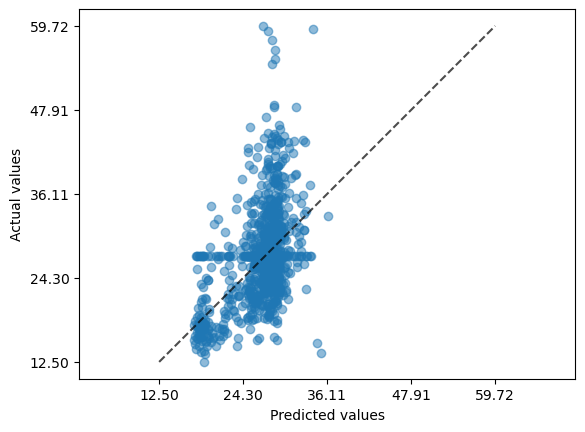

In [26]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_num_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)

### Поиск лучших гиперпараметров по сетке параметров

In [27]:
pipe_num_transform

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_age_HbA1c_glucose',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['age', 'HbA1c_level',
                                                   'blood_glucose_level'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=48),
                                            transformer=PowerTransformer()))])

In [28]:
param_grid = {
    "preprocessors__num_age_HbA1c_glucose__QuantReplace__threshold": [0, 0.01],
    "model__regressor__n_neighbors": np.arange(1, 50, 8),
    "model__regressor__weights": ["uniform", "distance"],
}

In [29]:
scorer = make_scorer(r2_score)

In [30]:
Pipe_GS = GridSearchCV(
    estimator=pipe_num_transform,
    param_grid=param_grid,
    cv=ShuffleSplit(n_splits=5),
    scoring=scorer,
)
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num_age_HbA1c_glucose',
                                                                         Pipeline(steps=[('QuantReplace',
                                                                                          QuantileReplacer(threshold=0.01)),
                                                                                         ('power',
                                                                                          PowerTransformer())]),
                                                                         ['age',
                                                                          'HbA1c_level',
                                                                          'blood_glucose_level'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=48),
                                                                   transformer=PowerTransformer()))]),
             param_grid={'model__regressor__n_neighbors': array([ 1,  9, 17, 25, 33, 41, 49]),
                         'model__regressor__weights': ['uniform', 'distance'],
                         'preprocessors__num_age_HbA1c_glucose__QuantReplace__threshold': [0,
                                                                                           0.01]},
             scoring=make_scorer(r2_score))

In [31]:
Pipe_GS.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num_age_HbA1c_glucose',
                                                                         Pipeline(steps=[('QuantReplace',
                                                                                          QuantileReplacer(threshold=0.01)),
                                                                                         ('power',
                                                                                          PowerTransformer())]),
                                                                         ['age',
                                                                          'HbA1c_level',
                                                                          'blood_glucose_level'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=48),
                                                                   transformer=PowerTransformer()))]),
             param_grid={'model__regressor__n_neighbors': array([ 1,  9, 17, 25, 33, 41, 49]),
                         'model__regressor__weights': ['uniform', 'distance'],
                         'preprocessors__num_age_HbA1c_glucose__QuantReplace__threshold': [0,
                                                                                           0.01]},
             scoring=make_scorer(r2_score))

In [32]:
Pipe_best = Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_age_HbA1c_glucose',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0)),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['age', 'HbA1c_level',
                                                   'blood_glucose_level'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=49),
                                            transformer=PowerTransformer()))])

In [33]:
Pipe_best.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_age_HbA1c_glucose',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0)),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['age', 'HbA1c_level',
                                                   'blood_glucose_level'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=49),
                                            transformer=PowerTransformer()))])

In [34]:
print(
    f"r2 на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train):.4f}"
)
print(f"r2 на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val):.4f}")

print(
    f"mse на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train, mse):.4f}"
)
print(
    f"mse на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val, mse):.4f}"
)

r2 на тренировочной выборке: 0.2646
r2 на валидационной выборке: 0.2322
mse на тренировочной выборке: 33.7877
mse на валидационной выборке: 34.9150


### Проанализируем результат

In [35]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__regressor__n_neighbors',
       'param_model__regressor__weights',
       'param_preprocessors__num_age_HbA1c_glucose__QuantReplace__threshold',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [36]:
DF_Pipe_results = DF_Pipe[
    [
        "param_model__regressor__n_neighbors",
        "param_model__regressor__weights",
        "param_preprocessors__num_age_HbA1c_glucose__QuantReplace__threshold",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]
cm = sns.light_palette("orange", as_cmap=True)
hl = DF_Pipe_results.sort_values(by="rank_test_score").style.background_gradient(
    cmap=cm
)
hl

,param_model__regressor__n_neighbors,param_model__regressor__weights,param_preprocessors__num_age_HbA1c_glucose__QuantReplace__threshold,mean_test_score,std_test_score,rank_test_score
24,49,uniform,0,0.231848,0.009844,1
25,49,uniform,0.010000,0.231670,0.010007,2
21,41,uniform,0.010000,0.229823,0.010174,3
20,41,uniform,0,0.229814,0.010071,4
16,33,uniform,0,0.227075,0.010502,5
17,33,uniform,0.010000,0.226681,0.010864,6
13,25,uniform,0.010000,0.221188,0.010795,7
12,25,uniform,0,0.220901,0.010823,8
9,17,uniform,0.010000,0.210270,0.008687,9
8,17,uniform,0,0.210262,0.008288,10


### Сохраняем модель

In [37]:
from joblib import dump

dump(model, "models_kNN/model.joblib")
dump(kNNbest, "models_kNN/kNNbest.joblib")
dump(Pipe_best, "models_kNN/Pipe_best_kNN.joblib")

['models_kNN/Pipe_best_kNN.joblib']